In [129]:
import cv2 as cv
import math
import matplotlib.pyplot as plt
#pip install opencv-python
#https://www.learnopencv.com/deep-learning-based-text-detection-using-opencv-c-python/
#https://github.com/opencv/opencv/blob/master/samples/dnn/text_detection.py

In [119]:
cv.__version__

'4.1.1'

In [120]:
model = 'frozen_east_text_detection.pb'
net = cv.dnn.readNet(model)

In [121]:
img='images/IMG_2211.JPG'
frame = cv.imread(img)
frame.shape

(3024, 4032, 3)

In [122]:
# Get frame height and width

inpWidth=640
inpHeight=640

height_ = frame.shape[0]
width_ = frame.shape[1]
rW = width_ / float(inpWidth)
rH = height_ / float(inpHeight)

In [123]:

blob = cv.dnn.blobFromImage(frame, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True)

In [124]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

In [125]:
net.setInput(blob)
output = net.forward(outputLayers)
 
scores = output[0]
geometry = output[1]

In [126]:
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

In [127]:
confThreshold=0.5
[boxes, confidences] = decode(scores, geometry, confThreshold)
nmsThreshold=0.5
indices = cv.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

In [128]:
kWinName = "EAST: An Efficient and Accurate Scene Text Detector"
cv.namedWindow(kWinName, cv.WINDOW_NORMAL)
label='fifa'
for i in indices:
        # get 4 corners of the rotated rect
        vertices = cv.boxPoints(boxes[i[0]])
        # scale the bounding box coordinates based on the respective ratios
        for j in range(4):
            vertices[j][0] *= rW
            vertices[j][1] *= rH
        for j in range(4):
            p1 = (vertices[j][0], vertices[j][1])
            p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
            cv.line(frame, p1, p2, (0, 255, 0), 3);

# Put efficiency information
cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))

# Display the frame
cv.imshow(kWinName,frame)
cv.waitKey(0)
cv.destroyAllWindows()

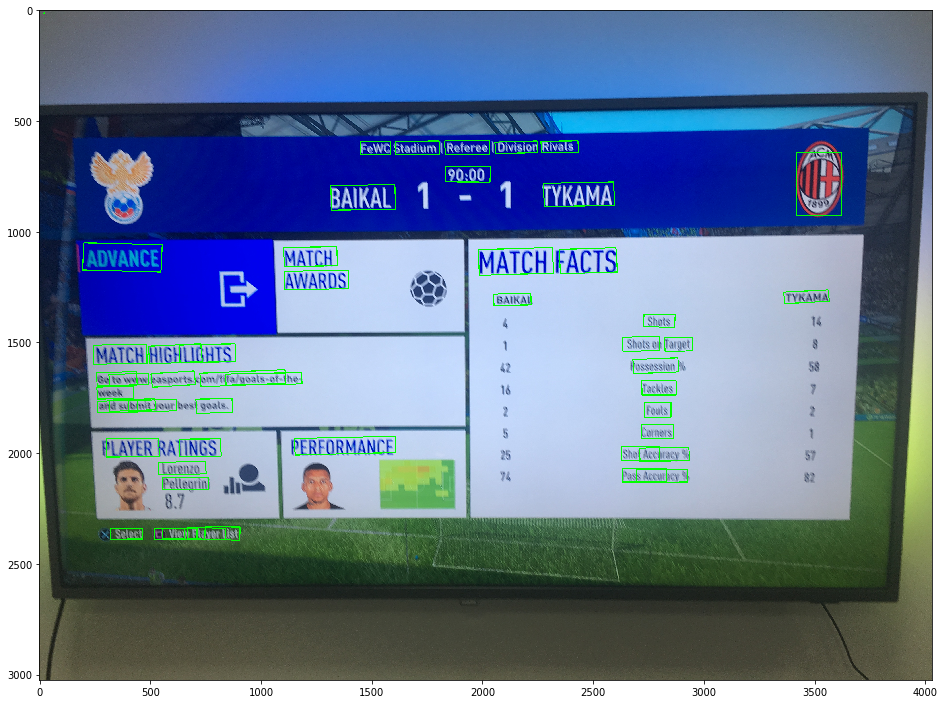

In [134]:
plt.figure(figsize=(16,16))
plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB))